# This Notebooks helps to recreate the pannels A-D in figure 2 of the paper: ARCOS.px

The code first identifies dense actin structures using the pixel classifier convpatint, then subsequently tracks those structures using AROCS.px


In [2]:
import napari
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage import measure
from arcos4py.tools import track_events_image
from napari_timestamper import render_as_rgb, save_image_stack
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from scipy import ndimage

import numpy as np
from scipy import ndimage
from skimage.morphology import binary_opening, square
from matplotlib_scalebar.scalebar import ScaleBar

from napari_convpaint import conv_paint_utils
import numpy as np
import napari
import cv2
from napari_convpaint import conv_paint
from tqdm.auto import tqdm

from skimage.util import map_array
from skimage.measure import regionprops


# set plot parameters for publication quality
from matplotlib import rcParams

plt.rcParams["svg.fonttype"] = "none"
rcParams["font.family"] = "Arial"

Info: Cellpose is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[cellpose]' to install it.


c:\Users\benig\miniconda3\envs\imageanalysis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# scale
pixel_scale = 0.11  # in um
plot_path = "../../data/3_podosome_tracks/output-plots/single_lineage_tracking"
rgb_path = "../../data/3_podosome_tracks/output-videos/single_lineage_tracking"

## Function definitions

In [3]:
from typing import Tuple, Optional, Callable, Union, Literal
from scipy.optimize import curve_fit

ExpFuncType = Callable[[np.ndarray, float, float], np.ndarray]

# Function type for _bi_exp
BiExpFuncType = Callable[[np.ndarray, float, float, float, float], np.ndarray]

# Union type for both function types
FuncType = Union[ExpFuncType, BiExpFuncType]


def _exp(x: np.ndarray, a: float, b: float) -> np.ndarray:
    return a * np.exp(-b * x)


def _bi_exp(x: np.ndarray, a: float, b: float, c: float, d: float) -> np.ndarray:
    return (a * np.exp(-b * x)) + (c * np.exp(-d * x))


def _exponential_correct(
    images: np.ndarray,
    contrast_limits: Optional[Tuple[int, int]] = None,
    method: Literal["mono", "bi"] = "mono",
) -> np.ndarray:
    """Corrects photobleaching in a 3D or 4D image stack using an exponential curve.

    Adapted from:
    https://github.com/marx-alex/napari-bleach-correct/blob/main/src/napari_bleach_correct/modules/exponential.py.
    """
    dtype = images.dtype
    if contrast_limits is None:
        contrast_limits = (np.min(images), np.max(images))
    assert 3 <= len(images.shape) <= 4, f"Expected 3d or 4d image stack, instead got {len(images.shape)} dimensions"

    avail_methods = ["mono", "bi"]
    func: FuncType
    if method == "mono":
        func = _exp
    elif method == "bi":
        func = _bi_exp
    else:
        raise NotImplementedError(f"method must be one of {avail_methods}, instead got {method}")

    axes = tuple(range(len(images.shape)))
    I_mean = np.mean(images, axis=axes[1:])
    x_data = np.arange(images.shape[0])

    with np.errstate(over="ignore"):
        try:
            popt, _ = curve_fit(func, x_data, I_mean)
            f_ = np.vectorize(func)(x_data, *popt)
        except (ValueError, RuntimeError, Warning):
            f_ = np.ones(x_data.shape)

    residuals = I_mean - f_
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((I_mean - np.mean(I_mean)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R^2: {r_squared}")

    f = f_ / np.max(f_)
    if len(images.shape) == 3:
        f = f.reshape(-1, 1, 1)
    else:
        f = f.reshape(-1, 1, 1, 1)
    images = images / f

    images[images < contrast_limits[0]] = contrast_limits[0]
    images[images > contrast_limits[1]] = contrast_limits[1]
    return images.astype(dtype)


def remap_segmentation(
    df: pd.DataFrame,
    segmentation: list,
    timepoint_column: str = "timepoint",
    label_column: str = "label",
    measure_column: str = "ERK",
) -> list:
    tracked_numpy = df[[timepoint_column, label_column, measure_column]].sort_values(timepoint_column).to_numpy()
    grouped_numpy = np.split(tracked_numpy, np.unique(tracked_numpy[:, 0], return_index=True)[1][1:])
    ratio_remapped = []
    for img, grp in zip(segmentation, grouped_numpy):
        img_copy = map_array(img, grp[:, 1], grp[:, 2])
        ratio_remapped.append(img_copy)
    return ratio_remapped

## Load the data

In [4]:
lifeact = io.imread("../../data/3_podosome_tracks/input-data/lifeact_podosomes.tif")

In [5]:
lifeact_bl = _exponential_correct(lifeact)

R^2: 0.9965979632582853


In [7]:
viewer = napari.Viewer()

In [ ]:
viewer.add_image(lifeact_bl, name="lifeact", colormap="magma", blending="additive")

<Image layer 'lifeact' at 0x234a4d9b1a0>

# Segment dense actin with Convpaint

### Add the plugin to napari and train a new model

In [ ]:
viewer.window.add_plugin_dock_widget("napari-convpaint")

Info: Cellpose is not installed and is not available as feature extractor.
Run 'pip install napari-convpaint[cellpose]' to install it.


(<napari._qt.widgets.qt_viewer_dock_widget.QtViewerDockWidget at 0x234b4547530>,
 <napari_convpaint.conv_paint_widget.ConvPaintWidget at 0x234b44c8b90>)

# Segment image with a pretrained convpaint model

In [6]:
# load the joblib file
classifier, model, param, _ = conv_paint.load_model("20250217_convpaint.pickle")

all_seg = []

if param.normalize:
    lifeact_bl_mean, lifeact_bl_std = conv_paint_utils.compute_image_stats(lifeact_bl)
    lifeact_bl_norm = conv_paint_utils.normalize_image(lifeact_bl, lifeact_bl_mean, lifeact_bl_std)

seg = np.zeros_like(lifeact_bl)

for t in tqdm(range(lifeact_bl.shape[0])):
    prediction = model.predict_image(lifeact_bl_norm[t], classifier, param)
    seg[t] = prediction

100%|██████████| 396/396 [00:44<00:00,  8.98it/s]


## Postprocess the segmentation

In [7]:
# get binary mask from the model
binary_mask = np.where(seg == 2, 1, 0)

In [8]:
from skimage.filters import rank

binary_mask_filtered = rank.majority(binary_mask.astype(np.uint8), footprint=np.ones((3, 2, 2)))

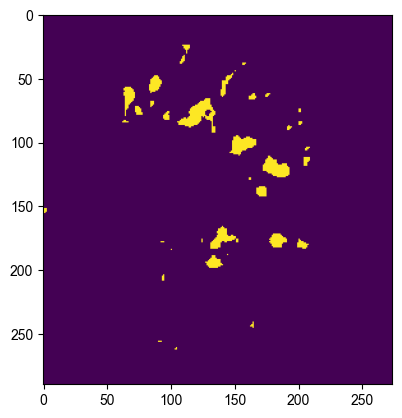

In [9]:
plt.imshow(binary_mask_filtered[0])

# Track events with AROS.px and plot the lineage tree

In [10]:
events, lineage = track_events_image(
    binary_mask_filtered,
    eps=1.5,
    eps_prev=5,
    min_clustersize=5,
    n_prev=15,
    allow_merges=True,
    allow_splits=True,
    stability_threshold=20,
    remove_small_clusters=True,
)

100%|██████████| 396/396 [00:19<00:00, 20.23it/s]


### Filter Lineages that are shorter than 10 frames

In [11]:
lineage_filtered = lineage.filter("lineage_duration", 10)
events_filtered = lineage_filtered.reflect(events)

### Save the results

In [ ]:
io.imsave(os.path.join(rgb_path, "filtered_events.tif"), events_filtered.astype(np.uint16))

### Plot Lineage tree for lineages that are longer than 60 frames (due to space constraints)

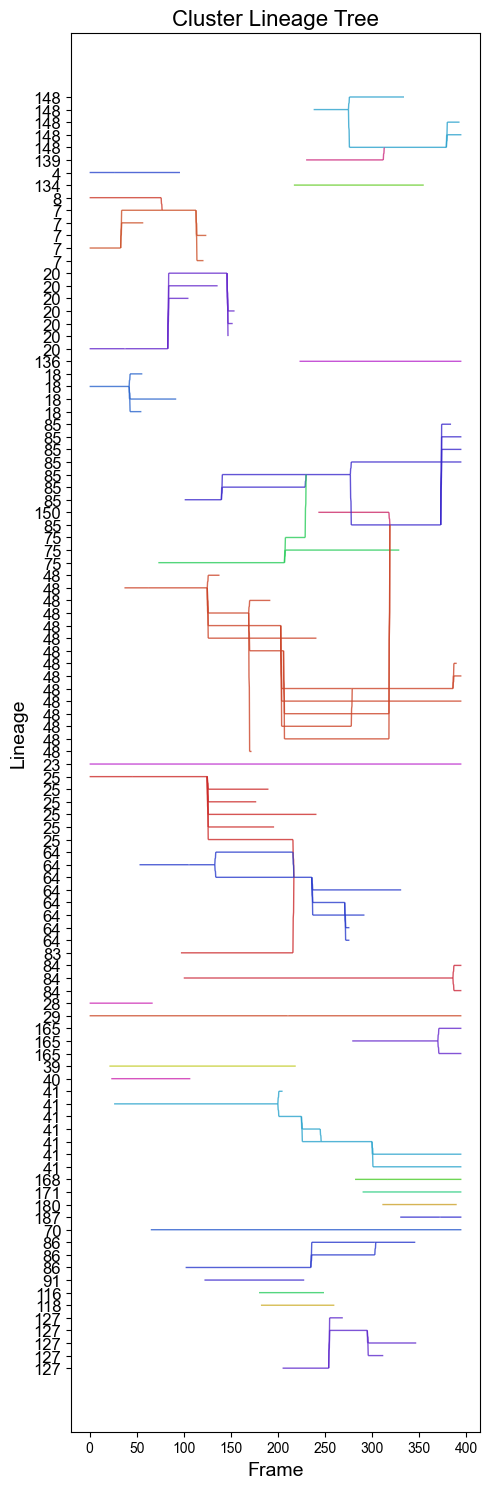

In [13]:
lineage.filter("lineage_duration", 60).plot(figsize=(5, 15), node_size=0, color_seed=0, edge_width=1)  # plot only
plt.savefig(os.path.join(plot_path, "lineage_filtered.svg"), dpi=100)

### Remap the event ids to their corresponding lineages

In [14]:
all_lineages_data = []

data = []

# Traverse nodes and aggregate lineage_id and event_id
for node in lineage_filtered.nodes.values():
    lid = node.lineage_id
    event_id = node.cluster_id
    data.append(
        {
            "lineage_id": lid,
            "event_id": event_id,
        }
    )

lineages_df = pd.DataFrame(data)
lineages_df.head()

,lineage_id,event_id
0,2,2
1,3,3
2,4,4
3,5,5
4,6,6


In [15]:
data = []
# create a lineage/label df
for i, frame_data in enumerate(events_filtered):
    for event in regionprops(frame_data):
        if event.label == 0:
            continue
        data.append(
            {
                "timepoint": i,
                "event": event.label,
                "lineage": lineage_filtered.nodes[event.label].lineage_id,
                "x": event.centroid[1],
                "y": event.centroid[0],
                "bbox-0": event.bbox[0],
                "bbox-1": event.bbox[1],
                "bbox-2": event.bbox[2],
                "bbox-3": event.bbox[3],
            }
        )

lineage_df = pd.DataFrame(data)

# remap the segmentation
events_lineage = remap_segmentation(
    lineage_df, events_filtered, timepoint_column="timepoint", label_column="event", measure_column="lineage"
)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(lifeact_bl, name="raw", colormap="gray_r", scale=[1, 0.11, 0.11])
lineage_id_layer = viewer.add_labels(
    np.array(events_lineage), name="lineage_ids", blending="translucent", opacity=1, scale=[1, 0.11, 0.11]
)
lineage_id_layer.new_colormap(seed=0)
lineage_id_layer.contour = 2
rgb_stack = render_as_rgb(viewer, 0, 4)

# hide the lineage layer and render the lifeact image alone
lineage_id_layer.visible = False
rgb_lifeact = render_as_rgb(viewer, 0, 4)
viewer.close()

### Draw Bounding boxes arround the tracked podosomes

In [22]:
alpha_box = 0.5  # Transparency for bounding box
alpha_label = 0.5  # Transparency for label background
outline_color = (255, 255, 255)  # White outline
label_bg_color = (255, 255, 255)  # White background for label
text_color = (0, 0, 0, 255)  # Black text
annotated_stack = rgb_stack.copy()
for i, frame in enumerate(annotated_stack):
    lineage_df_frame = lineage_df[lineage_df["timepoint"] == i]

    overlay = frame.copy()

    for _, row in lineage_df_frame.iterrows():
        minr = int(row["bbox-0"])
        minc = int(row["bbox-1"])
        maxr = int(row["bbox-2"])
        maxc = int(row["bbox-3"])

        # Scale due to upsampling
        scale = 4
        minr, minc, maxr, maxc = (val * scale for val in (minr, minc, maxr, maxc))

        x_min, y_min = minc, minr
        x_max, y_max = maxc, maxr

        cv2.rectangle(overlay, (x_min, y_min), (x_max, y_max), outline_color, thickness=2)

        label = f"ID:{row['event']:.0f}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.7
        text_thickness = 2

        (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, text_thickness)
        label_height = text_height + baseline

        label_x1 = x_min
        label_y2 = y_min
        label_x2 = x_min + text_width
        label_y1 = label_y2 - label_height

        label_y1 = max(label_y1, 0)

        cv2.rectangle(overlay, (label_x1, label_y1), (label_x2, label_y2), label_bg_color, -1)

    cv2.addWeighted(overlay, alpha_box, frame, 1 - alpha_box, 0, frame)

    for _, row in lineage_df_frame.iterrows():
        label = f"ID:{row['event']:.0f}"
        font_scale = 0.7
        text_thickness = 1

        minr = int(row["bbox-0"])
        minc = int(row["bbox-1"])
        maxr = int(row["bbox-2"])
        maxc = int(row["bbox-3"])
        scale = 4
        minr, minc, maxr, maxc = (val * scale for val in (minr, minc, maxr, maxc))

        x_min, y_min = minc, minr

        (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, text_thickness)
        label_height = text_height + baseline
        label_x1 = x_min
        label_y2 = y_min
        label_x2 = x_min + text_width
        label_y1 = label_y2 - label_height
        label_y1 = max(label_y1, 0)

        text_x = label_x1
        text_y = label_y2 - baseline

        cv2.putText(
            frame,
            label,
            (text_x, text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            text_color,
            text_thickness,
            cv2.LINE_AA,
        )

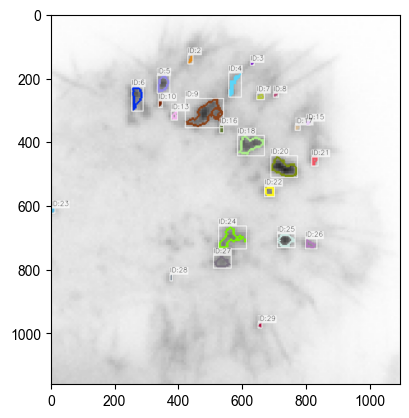

In [23]:
plt.imshow(annotated_stack[0])

### Save RGB stack with annotated boundingboxes

In [24]:
io.imsave(os.path.join(rgb_path, "tracked_podosomes_with_bbox.tif"), annotated_stack)
io.imsave(os.path.join(rgb_path, "lifact_rgb.tif"), rgb_lifeact)

### Export 3D projection of tracked lineages

In [ ]:
# create 3d projection of the filtered events
viewer = napari.Viewer()
viewer.add_image(np.asanyarray(lifeact_bl), name="lifeact", colormap="gray_r", blending="additive")
layer = viewer.add_labels(np.asanyarray(events_lineage), name="filtered_events")
layer.new_colormap(seed=0)
# set to 3d view
viewer.dims.ndisplay = 3

# rotate camera
viewer.camera.angles = (-168.11662445864758, 53.35033997701048, -76.01549157776886)
layer.bounding_box.visible = True
layer.bounding_box.line_thickness = 80
layer.bounding_box.line_color = "black"
layer.iso_gradient_mode = "smooth"
viewer.camera.zoom = 1.5
for layer in viewer.layers:
    layer.scale = [1, 0.4, 1]

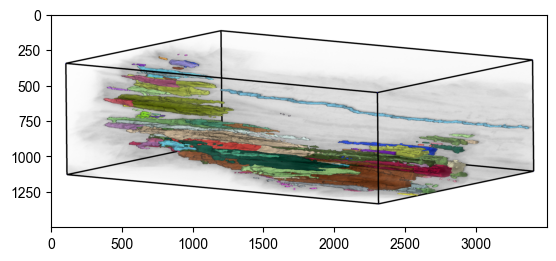

In [ ]:
screen = viewer.screenshot(os.path.join(plot_path, "3d_projection_lineage.png"), scale=2)
plt.imshow(screen[:1500, 500:4000])
viewer.close()

### Create Movie Pannel Overviews

In [ ]:
viewer = napari.Viewer()
viewer.add_image(np.asanyarray(lifeact_bl), name="lifeact", colormap="gray_r", blending="additive")
layer = viewer.add_labels(np.asanyarray(events_filtered), name="filtered_events")
layer.new_colormap(seed=0)

In [ ]:
samples = np.linspace(0, 360, 3, dtype=int)

rgb_events = []
rbg_lifeact = []
viewer.layers["lifeact"].visible = True
viewer.layers["filtered_events"].visible = True
for img in samples:
    viewer.dims.set_current_step(0, img)
    rgb_events.append(render_as_rgb(viewer, upsample_factor=1))

viewer.layers["filtered_events"].visible = False

for img in samples:
    viewer.dims.set_current_step(0, img)
    rbg_lifeact.append(render_as_rgb(viewer, upsample_factor=1))

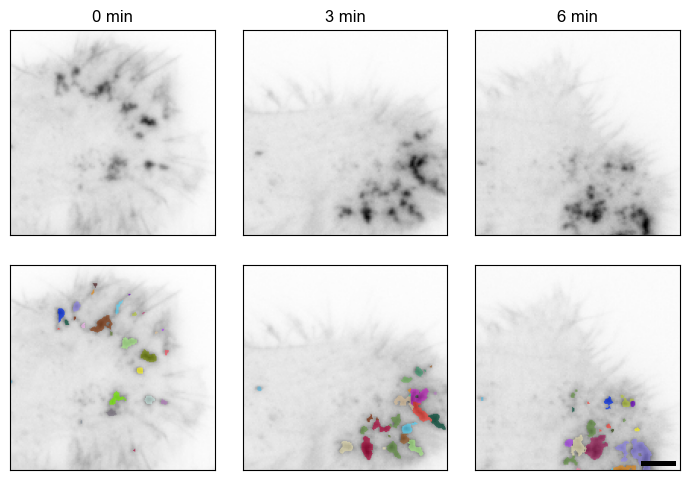

In [ ]:
plt.rcParams["svg.fonttype"] = "none"
# set font to arial
plt.rcParams["font.sans-serif"] = "Arial"


fig, ax = plt.subplots(2, 3, figsize=(7, 5))

for idx, val in enumerate(samples):
    cropped_img = rbg_lifeact[idx][:270, :270]
    ax[0, idx].imshow(cropped_img)
    ax[0, idx].set_xticks([])
    ax[0, idx].set_yticks([])
    # in minutes
    ax[0, idx].set_title(f"{val*1/60:.0f} min")

for idx, val in enumerate(samples):
    cropped_label = rgb_events[idx][:270, :270]
    ax[1, idx].imshow(cropped_label)
    ax[1, idx].set_xticks([])
    ax[1, idx].set_yticks([])
    if val == samples[-1]:
        scalebar = ScaleBar(
            0.11, "um", location="lower right", scale_loc="none", box_alpha=0, width_fraction=0.025, fixed_value=5
        )
        ax[1, idx].add_artist(scalebar)

plt.tight_layout(h_pad=2, w_pad=2)
plt.savefig(os.path.join(plot_path, "pannels.svg"), dpi=600)
# scalebar = 5 um

### Crop 1 for split merge demonstration

In [ ]:
# get the event id
event_id = 81

# get the frames of the event
event_frames = np.where(events_filtered == event_id)

# get the first frame of the event
first_frame = event_frames[0][0] - 30

# get bounding box of the event
bbox = ndimage.find_objects(events_filtered == event_id)[0]
# add 10 pixels to the bounding box and start 1' frames before the event
bbox = tuple(slice(max(0, i.start - 5), min(i.stop - 5, j)) for i, j in zip(bbox, events_filtered.shape))
bbox = (slice(bbox[0].start - 60, bbox[0].stop), bbox[1], bbox[2])

# crop the event
cropped_event_actin = lifeact_bl[bbox]
cropped_event = events_filtered[bbox]
# plot 10 frames as a sequence of the event cropped to the bounding box
# add to napari viewer
viewer = napari.Viewer()
viewer.add_image(cropped_event_actin, name="actin", colormap="gray_r")
labels = viewer.add_labels(cropped_event, name="tracked waves")
labels.new_colormap(seed=0)
labels.contour = 2
labels.opacity = 1
labels.new_colormap(seed=0)

In [ ]:
# create rgb images of the event

rgb_event = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.layers["tracked waves"].visible = False
rgb_actin_only = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.close()

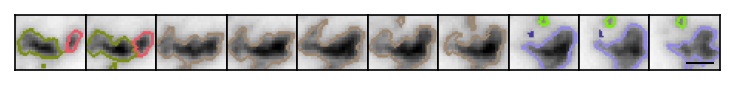

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(5, 2), dpi=150)
for idx, val in enumerate(range(0, 100, 10)):
    ax[idx].imshow(rgb_event[val])
    # remove ticks
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    # Add text to the upper left corner
    # ax[idx].text(0.05, 0.95, f'{val*1:.0f} sec', transform=ax[idx].transAxes,
    #                 fontsize=6, verticalalignment='top', horizontalalignment='left')
    ax[idx].margins(0, 0)

plt.tight_layout(h_pad=0, w_pad=0)
scalebar = ScaleBar(
    0.11 / 4, "um", fixed_value=2, location="lower right", scale_loc="none", box_alpha=0, width_fraction=0.025
)  # 2um scalebar
ax[-1].add_artist(scalebar)
plt.savefig(os.path.join(plot_path, "event_sequence_2.svg"), dpi=600)
# add scalebar to the last image
plt.show()

### Crop 2 for Split merge demonstration

In [ ]:
from napari_timestamper import render_as_rgb

# make crop of single event and follow it over time with high temporal resolution

# get the event id
event_id = 26

# get the frames of the event
event_frames = np.where(events_filtered == event_id)

# get the first frame of the event
first_frame = event_frames[0][0]

# get bounding box of the event
bbox = ndimage.find_objects(events_filtered == event_id)[0]
# add 10 pixels to the bounding box
bbox = tuple(slice(max(0, i.start - 25), min(i.stop + 5, j)) for i, j in zip(bbox, events_filtered.shape))


# crop the event
cropped_event_actin = lifeact_bl[bbox]
cropped_event = events_filtered[bbox]
# plot 10 frames as a sequence of the event cropped to the bounding box
# add to napari viewer
viewer = napari.Viewer()
viewer.add_image(cropped_event_actin, name="actin", colormap="gray_r")
labels = viewer.add_labels(cropped_event, name="tracked waves")
labels.new_colormap(seed=0)
labels.contour = 2
labels.opacity = 1
labels.new_colormap(seed=0)

In [ ]:
# create rgb images of the event

rgb_event = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.layers["tracked waves"].visible = False
rgb_actin_only = render_as_rgb(viewer, axis=0, upsample_factor=4)
viewer.close()

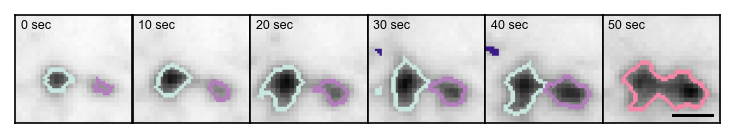

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 6, figsize=(5, 2), dpi=150)
for idx, val in enumerate(range(first_frame, first_frame + 60, 10)):
    ax[idx].imshow(rgb_event[val])
    # remove ticks
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    # Add text to the upper left corner
    ax[idx].text(
        0.05,
        0.95,
        f"{val*1:.0f} sec",
        transform=ax[idx].transAxes,
        fontsize=6,
        verticalalignment="top",
        horizontalalignment="left",
    )
    ax[idx].margins(0, 0)

plt.tight_layout(h_pad=0, w_pad=0)
scalebar = ScaleBar(
    0.11 / 4, "um", fixed_value=2, location="lower right", scale_loc="none", box_alpha=0, width_fraction=0.025
)  # 2um scalebar
ax[-1].add_artist(scalebar)
plt.savefig(os.path.join(plot_path, "event_sequence.svg"), dpi=600)
# add scalebar to the last image
plt.show()